In [2]:
from censys.search import CensysHosts
import pandas as pd
import re

### **Purpose**
The purpose of this code is to use the Censys search engine to find hosts running Confluence on the HTTP service. The goal is to determine out of the distinct count of queried hosts, how many are running a version of confluence vulnerable to the [CVE-2022-26134](https://nvd.nist.gov/vuln/detail/CVE-2022-26134) vulnerability. This vulnerability has a CVSS of 9.8, as it allows for unathenticated remote code execution.\
This analysis was inspired by [this](https://censys.io/cve-2022-26134-confluenza-omicron-edition/) Censys blog post written by Mark Ellzey.\
**Note**: You must authenticate using your own Censys API ID and secret using the command line before running this code.

### **Code**

The **getServices** function will loop through a set of hosts and return the count of different services running on each host.

In [107]:
def getServices(distinctHosts, allHosts):
        serviceDict = {}
        listHosts = list(distinctHosts)
        serviceList = []

        for i in range(0,len(listHosts)):
            currentHost = allHosts[listHosts[i]]
            for j in range(0,len(currentHost['services'])):
                service = currentHost['services'][j]['service_name']
                if service not in serviceDict:
                    serviceDict[service] = 1
                else:
                    serviceDict[service] += 1
            serviceList.append(serviceDict)
            serviceDict = {}
        return serviceList

The **getVersion** function will loop through a set of hosts and return the version of confluence running on the HTTP service.

In [25]:
def getVersion(distinctHosts, allHosts):
        listHosts = list(distinctHosts)
        versions = []
        for i in range(0,len(listHosts)):
            currentHost = allHosts[listHosts[i]]
            for j in range(0,len(currentHost['services'])):
                try: # using a try/except loop allows to find the Confluence version no. even if a host is running more than a single HTTP service
                    path = currentHost['services'][j]['http']['response']['html_tags']
                    for k in range(0,len(path)):
                        if path[k].startswith('<meta name="ajs-version-number"'):
                            tag = path[k]
                            version = re.sub(r'.*content="(.*)">',r'\1',tag)
                            # this if statement will find additional Confluence versions running on the same host, but separate HTTP service
                            if len(versions) == len(listHosts): 
                                break
                            else:
                                versions.append(version)
                except:
                    None
        return versions  

The **cleanHosts** function will clean up the ip addresses of the hosts, as the API may concatenate the name of the host.

In [26]:
def cleanHosts(distinctHosts):
    hosts = []
    for i in distinctHosts:
        pattern = re.compile(r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})') # IP address validation using regex
        hosts.append(pattern.search(i)[0])
    return hosts

The **findVulnerableHosts** function loops through a set of hosts and determines if it is running a Confluence version vulnerable to CVE-2022-26134.

In [6]:
def findVulnerableHosts(versions):
    vulnerableVersions = [
    '6.15.2',
    '6.15.4',
    '7.4.0',
    '7.4.6',
    '7.4.11',
    '7.4.13',
    '7.9.3',
    '7.12.5',
    '7.13.0',
    '7.13.1',
    '7.13.2',
    '7.13.3',
    '7.13.4',
    '7.13.5',
    '7.13.6',
    '7.14.1',
    '7.15.0',
    '7.16.1',
    '7.16.2',
    '7.17.1',
    '7.17.2'
    ]
    
    vulnerable = []
    for i in versions:
        if i in vulnerableVersions:
            vulnerable.append(True)
        else:
            vulnerable.append(False)
    return vulnerable

The **main** function takes the argument *numberOfHosts* and uses it to return a specific number of hosts. It finds hosts using the Censys Search API and filters by:

> **(1)** at least one running HTTP service and **(2)** contains "Confluence" in the html title of the HTTP response header
  

It runs the hosts through the functions above to return a dataframe that describes:

> **(1)** count of services running on a host, **(2)** its version(s) of Confluence, and **(3)** if that version is vulnerable to CVE-2022-26134

In [27]:
def main(numberOfHosts):
    searchQuery = "service.service_name: HTTP and services.http.response.html_title:`*Confluence*`"
    
    h = CensysHosts()
    query = h.search(
        searchQuery,
        per_page=numberOfHosts,
        virtual_hosts="INCLUDE" 
        )
    
    allHosts = query.view_all()   
    distinctHosts = allHosts.keys()
    
    services = getServices(distinctHosts, allHosts)
    versions = getVersion(distinctHosts, allHosts)
    hosts = cleanHosts(distinctHosts)
    vulnerable = findVulnerableHosts(versions)
    
    servicesDF = pd.DataFrame(
        data = services,
        index = hosts
        )
    servicesDF = servicesDF.fillna(0).astype(int)
    
    versionsDF = pd.DataFrame(
        data = versions,
        columns = ['Confluence Version No.'],
        index = hosts
        )
    
    
    vulnerableDF = pd.DataFrame(
        data = vulnerable,
        columns=['CVE-2022-26134 Vulnerable'],
        index = hosts
    )    
  
    finalDF = pd.merge(
                pd.merge(servicesDF, versionsDF, how="outer", left_index=True, right_index=True), 
                vulnerableDF, how="outer", left_index=True, right_index=True
                )
    return finalDF

In [72]:
finalDF = main(70)

### **Analysis**

This dataframe shows all the hosts found running Confluence on an HTTP service, along with a count of other services it is running.\
**Note**: Several instances of the same host are running many instances of Confluence on separate ports.

In [78]:
# Resetting index
finalDF = finalDF.rename_axis('Host IP')
finalDF = finalDF.reset_index()
finalDF

,Host IP,NETBIOS,SMB,RDP,POSTGRES,HTTP,SSH,MYSQL,UNKNOWN,NTP,FTP,PORTMAP,MSSQL,SMTP,REDIS,Confluence Version No.,CVE-2022-26134 Vulnerable
0,1.116.232.81,0,0,0,0,2,1,1,0,1,0,1,0,0,0,9.3.1,False
1,1.117.115.51,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5.8.10,False
2,1.117.166.79,0,0,0,0,3,1,0,0,1,0,0,0,0,0,8.9.1,False
3,1.117.188.132,0,0,0,0,2,1,1,1,1,0,1,0,0,0,7.20.1,False
4,1.117.98.240,0,0,0,1,3,1,1,0,0,0,0,0,0,0,8.20.13,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,3.8.243.147,0,0,0,0,2,1,0,0,0,0,0,0,0,0,7.19.4,False
606,3.8.243.147,0,0,0,0,2,1,0,0,0,0,0,0,0,0,7.19.4,False
607,3.8.243.147,0,0,0,0,2,1,0,0,0,0,0,0,0,0,7.18.1,False
608,3.8.243.147,0,0,0,0,2,1,0,0,0,0,0,0,0,0,7.18.1,False


Host *2.59.41.48* is running a significant amount of Confluence instances (128) vulnerable to CVE-2022-26134, compared to other hosts. My assumption is that this host is running many virtual hosts. Companies may do this to allocate different resources to different departments.

In [195]:
hosts = finalDF['Host IP'].unique() # creating an array of unique hosts
groupHosts = finalDF.groupby('Host IP') # grouping by Host IP to count up many instances per one host

# creating an array with vulnerable version count per host
vuls = []
for i in range(0,len(hosts)):
    currentHost = groupHosts.get_group(hosts[i])
    vulCount = currentHost['CVE-2022-26134 Vulnerable'].sum()
    vuls.append(vulCount)

# creating a dictionary that shows the count of vulnerable versions found by host
vulPerHost = {}
for i in range(0,len(hosts)):
    vulPerHost[hosts[i]] = [vuls[i]]

# creating a simple dataframe to show the count of vulnerable versions running on each host
df = pd.DataFrame.from_dict(vulPerHost,orient='index', columns=['Vulnerable Version Count'])
df = df[df['Vulnerable Version Count'] != 0]
df

,Vulnerable Version Count
1.12.52.13,1
1.13.250.78,1
1.14.131.139,1
1.15.46.86,1
1.202.249.120,4
1.7.184.114,1
1.71.161.14,1
2.59.41.48,128


The bar chart below visualizes hosts and their count of vulnerable Confluence instances.

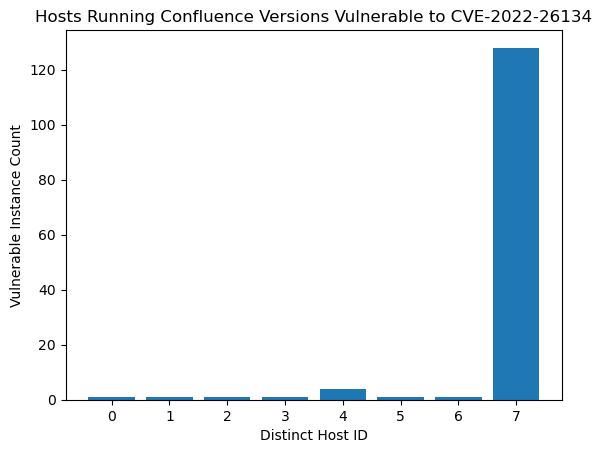

In [193]:
import matplotlib.pyplot as plt

names = list(vulPerHost.keys())
values = list(vulPerHost.values())
plt.bar(range(len(df)), df["Vulnerable Version Count"])
plt.title("Hosts Running Confluence Versions Vulnerable to CVE-2022-26134")
plt.xlabel("Distinct Host ID")
plt.ylabel("Vulnerable Instance Count")
plt.show()

**Conclusion**: 57 distinct hosts were queried using the Censys Search API. These hosts were found using the filters:

> **(1)** at least one running HTTP service and **(2)** contains "Confluence" in the html title of the HTTP response header

The analyst found that **14%** of 57 distinct hosts found were running one or more instances of Confluence vulnerable to CVE-2022-26134, this calculation is shown below. The host with the most vulnerable instances of Confluence can be traced to Russia. This host is likely running many virtual hosts, which are contributing to the high count of **128** vulnerable Confluence instances.

In [178]:
vulHosts = df.count()
vulHosts/len(hosts)*100

Vulnerable Version Count    14.035088
dtype: float64